# Banco Source — Análise de Crédito

Este notebook apresenta o pipeline completo de análise de crédito do Banco Source, desde a preparação dos dados até a avaliação dos modelos preditivos.

**Objetivo:** identificar perfis de inadimplência e construir modelos que apoiem a concessão de crédito de forma mais segura e eficiente.

---

## 1. Importações e configuração

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay
)

import warnings
warnings.filterwarnings('ignore')

# Estilo dos gráficos
plt.rcParams.update({
    'figure.dpi': 120,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.family': 'sans-serif'
})

SEED = 42
np.random.seed(SEED)

---

## 2. Geração do dataset

Simulamos 10.000 registros de clientes com características financeiras e comportamentais. O target é a coluna `inadimplente` (1 = inadimplente, 0 = adimplente).

In [2]:
n = 10_000

score_credito      = np.random.normal(loc=600, scale=100, size=n).clip(300, 900).astype(int)
renda_mensal       = np.random.lognormal(mean=8.5, sigma=0.6, size=n).clip(1000, 50000).round(2)
idade              = np.random.randint(18, 75, size=n)
meses_relacionamento = np.random.randint(1, 120, size=n)
num_produtos       = np.random.randint(1, 7, size=n)
historico_pagamentos = np.random.choice(['Bom', 'Regular', 'Ruim'], size=n, p=[0.55, 0.30, 0.15])

# Gerar inadimplência correlacionada com as variáveis
prob_inadimplencia = (
    0.25
    - 0.0003 * score_credito
    - 0.000002 * renda_mensal
    + 0.003 * (historico_pagamentos == 'Ruim').astype(int)
    + np.random.normal(0, 0.05, n)
).clip(0.02, 0.95)

inadimplente = (np.random.rand(n) < prob_inadimplencia).astype(int)

df = pd.DataFrame({
    'score_credito': score_credito,
    'renda_mensal': renda_mensal,
    'idade': idade,
    'meses_relacionamento': meses_relacionamento,
    'num_produtos': num_produtos,
    'historico_pagamentos': historico_pagamentos,
    'inadimplente': inadimplente
})

print(f'Dataset gerado: {df.shape[0]:,} linhas x {df.shape[1]} colunas')
print(f'Taxa de inadimplência: {df["inadimplente"].mean():.1%}')
df.head()

Dataset gerado: 10,000 linhas x 7 colunas
Taxa de inadimplência: 6.7%


,score_credito,renda_mensal,idade,meses_relacionamento,num_produtos,historico_pagamentos,inadimplente
0,649,3271.17,49,103,5,Ruim,0
1,586,4091.64,34,70,1,Bom,0
2,664,3434.31,35,97,5,Bom,0
3,752,5251.40,74,111,5,Bom,0
4,576,10079.99,21,91,3,Regular,0


---

## 3. Preparação dos dados

In [3]:
# Verificação de valores nulos
print('Valores nulos por coluna:')
print(df.isnull().sum())

print('\nTipos de dados:')
print(df.dtypes)

Valores nulos por coluna:
score_credito           0
renda_mensal            0
idade                   0
meses_relacionamento    0
num_produtos            0
historico_pagamentos    0
inadimplente            0
dtype: int64

Tipos de dados:
score_credito             int64
renda_mensal            float64
idade                     int32
meses_relacionamento      int32
num_produtos              int32
historico_pagamentos     object
inadimplente              int64
dtype: object


In [4]:
# Encoding da variável categórica
le = LabelEncoder()
df['historico_cod'] = le.fit_transform(df['historico_pagamentos'])

print('Mapeamento historico_pagamentos:')
for cls, code in zip(le.classes_, le.transform(le.classes_)):
    print(f'  {cls} -> {code}')

Mapeamento historico_pagamentos:
  Bom -> 0
  Regular -> 1
  Ruim -> 2


---

## 4. Análise exploratória

In [5]:
# Estatísticas descritivas
df.describe().round(2)

,score_credito,renda_mensal,idade,meses_relacionamento,num_produtos,inadimplente,historico_cod
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,599.29,5933.08,46.11,59.73,3.52,0.07,0.60
std,100.07,3905.88,16.51,34.81,1.71,0.25,0.73
min,300.00,1000.00,18.00,1.00,1.00,0.00,0.00
25%,532.00,3303.68,32.00,29.00,2.00,0.00,0.00
50%,599.00,4961.73,46.00,59.00,4.00,0.00,0.00
75%,667.00,7452.60,60.00,91.00,5.00,0.00,1.00
max,900.00,50000.00,74.00,119.00,6.00,1.00,2.00


In [6]:
# Distribuição do target
contagem = df['inadimplente'].value_counts()
print('Distribuição do target:')
print(contagem.rename({0: 'Adimplente', 1: 'Inadimplente'}))

Distribuição do target:
inadimplente
Adimplente      9327
Inadimplente     673
Name: count, dtype: int64


In [7]:
# Comparativo de médias por grupo
numericas = ['score_credito', 'renda_mensal', 'idade', 'meses_relacionamento', 'num_produtos']
df.groupby('inadimplente')[numericas].mean().round(2).rename(index={0: 'Adimplente', 1: 'Inadimplente'})

,score_credito,renda_mensal,idade,meses_relacionamento,num_produtos
inadimplente,,,,,
Adimplente,602.16,5947.92,46.09,59.73,3.52
Inadimplente,559.53,5727.49,46.44,59.73,3.50


---

## 5. Visualizações

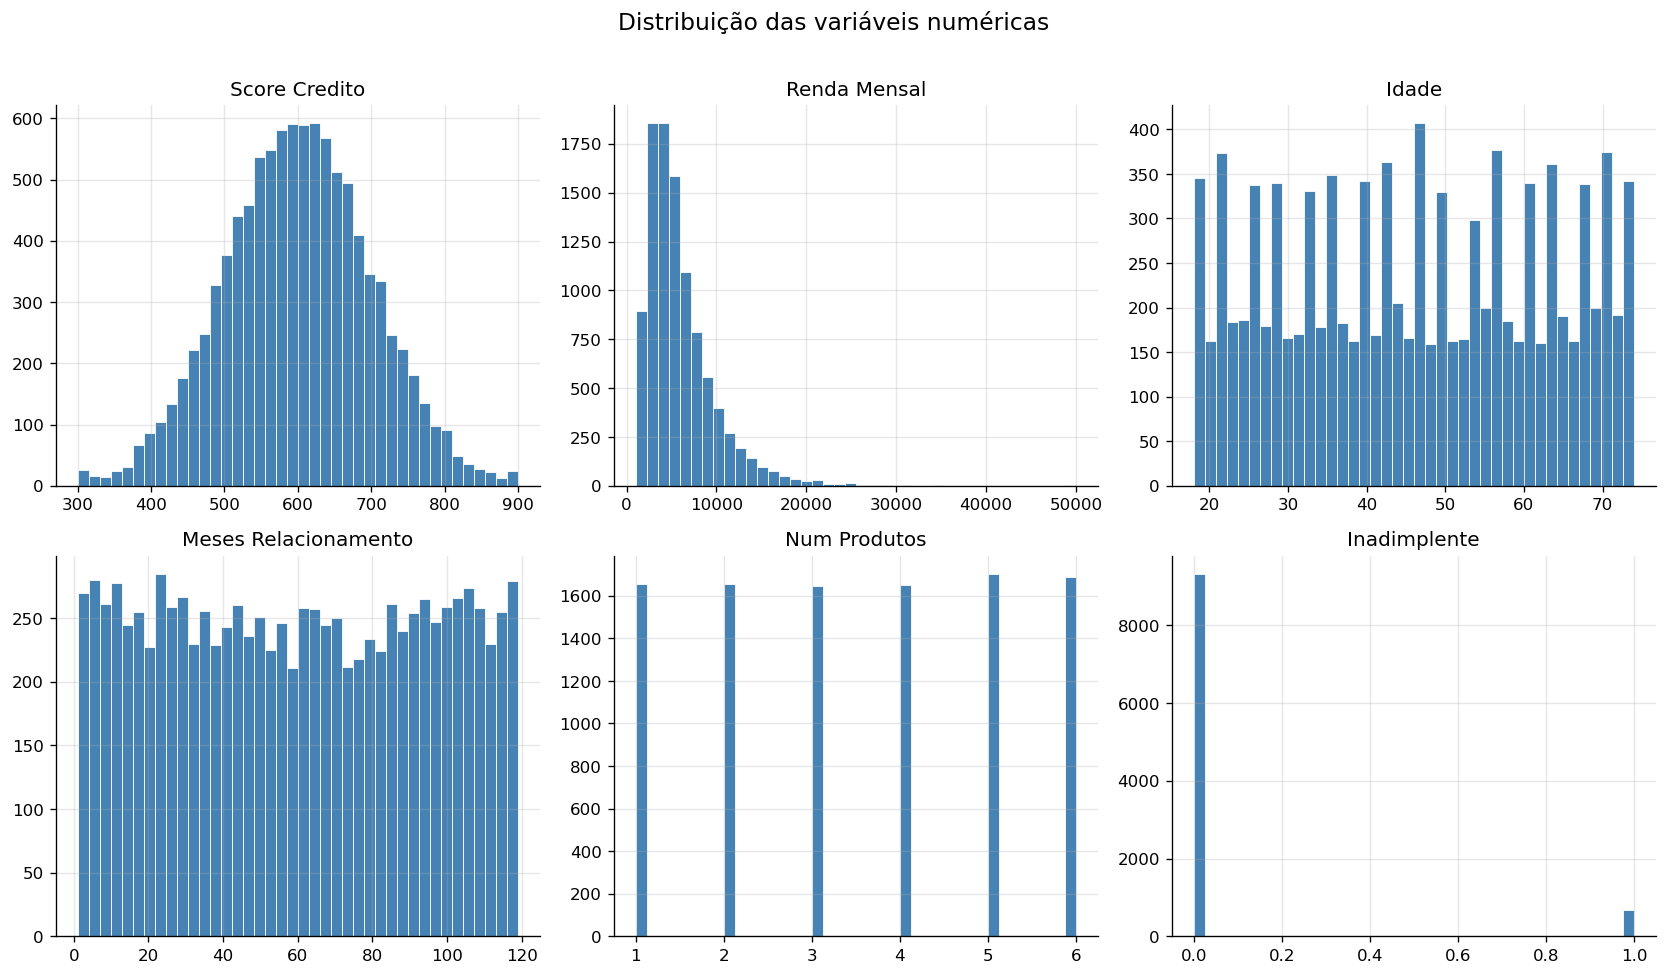

In [8]:
# Histogramas das variáveis numéricas
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('Distribuição das variáveis numéricas', fontsize=14, y=1.01)

cols = numericas + ['inadimplente']
for ax, col in zip(axes.flat, cols):
    ax.hist(df[col], bins=40, color='steelblue', edgecolor='white', linewidth=0.5)
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

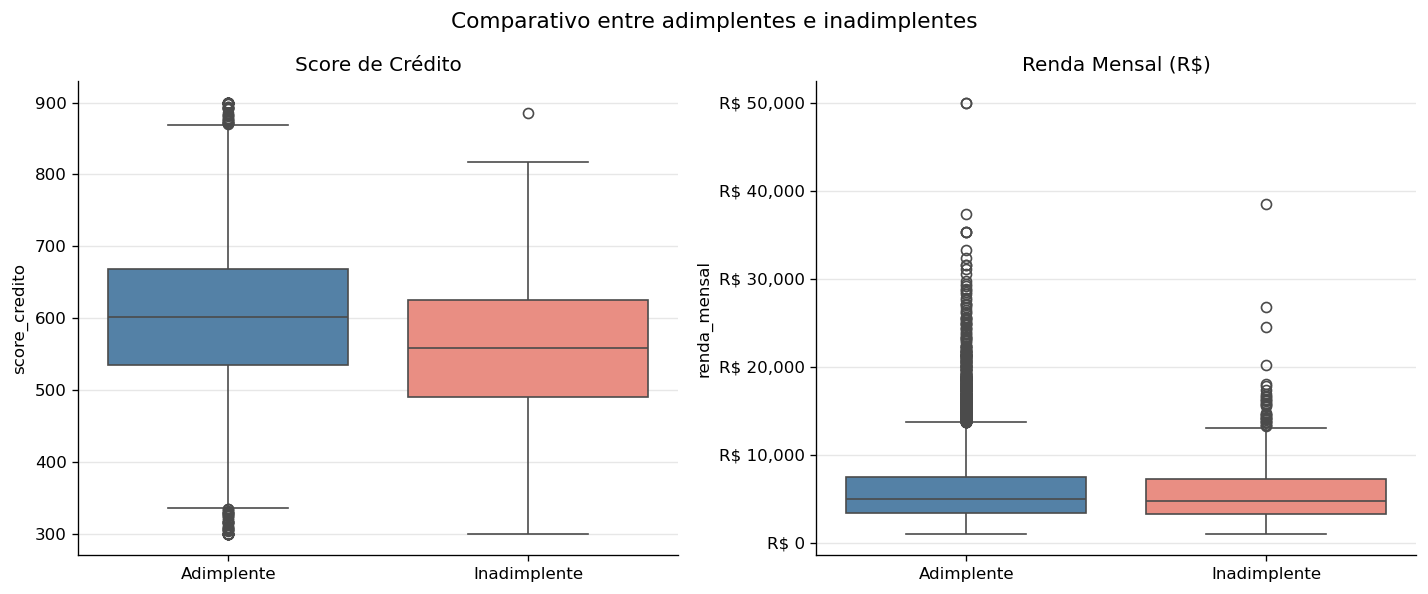

In [9]:
# Boxplots: score e renda por grupo de inadimplência
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Comparativo entre adimplentes e inadimplentes', fontsize=13)

labels = {0: 'Adimplente', 1: 'Inadimplente'}
df['grupo'] = df['inadimplente'].map(labels)

sns.boxplot(data=df, x='grupo', y='score_credito', palette=['steelblue', 'salmon'], ax=axes[0])
axes[0].set_title('Score de Crédito')
axes[0].set_xlabel('')

sns.boxplot(data=df, x='grupo', y='renda_mensal', palette=['steelblue', 'salmon'], ax=axes[1])
axes[1].set_title('Renda Mensal (R$)')
axes[1].set_xlabel('')
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R$ {x:,.0f}'))

plt.tight_layout()
plt.show()

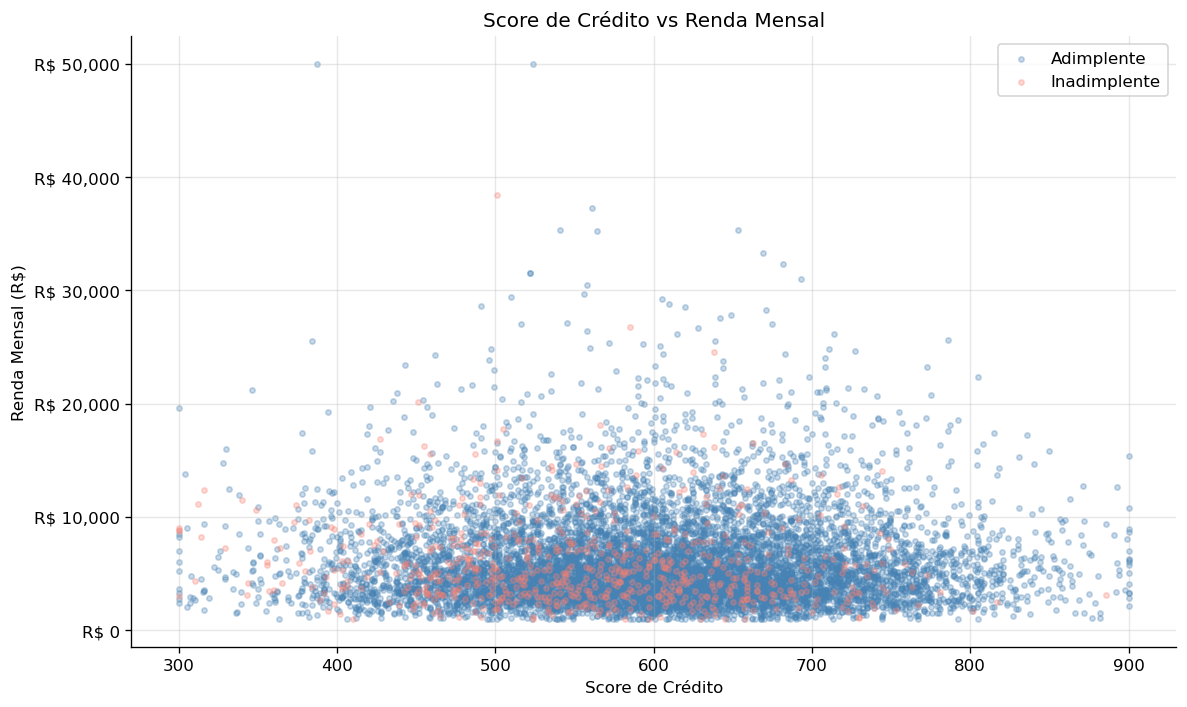

In [10]:
# Dispersão: score vs renda, colorido por inadimplência
fig, ax = plt.subplots(figsize=(10, 6))

for grupo, cor, label in [(0, 'steelblue', 'Adimplente'), (1, 'salmon', 'Inadimplente')]:
    subset = df[df['inadimplente'] == grupo]
    ax.scatter(subset['score_credito'], subset['renda_mensal'],
               alpha=0.3, s=10, color=cor, label=label)

ax.set_title('Score de Crédito vs Renda Mensal')
ax.set_xlabel('Score de Crédito')
ax.set_ylabel('Renda Mensal (R$)')
ax.legend()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'R$ {x:,.0f}'))

plt.tight_layout()
plt.show()

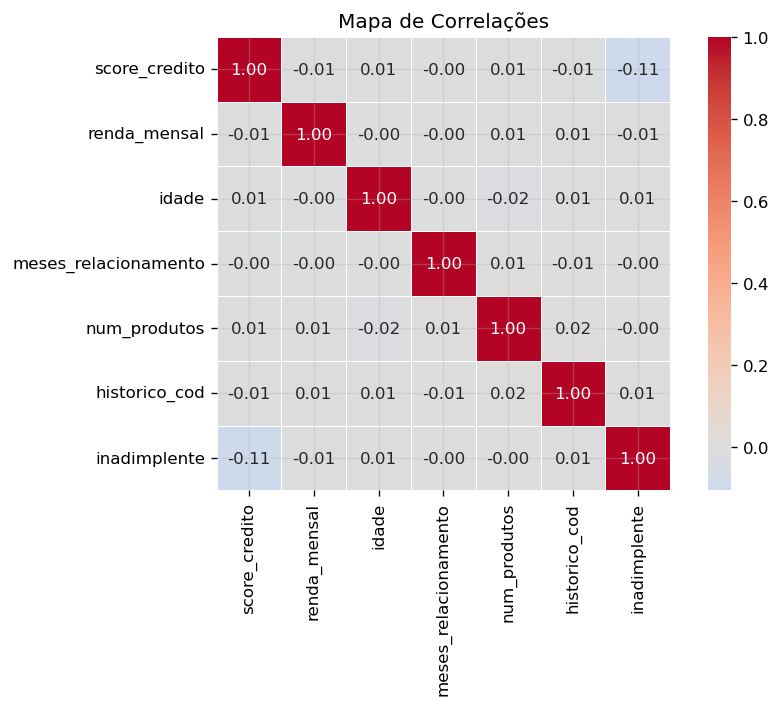

In [11]:
# Heatmap de correlações
fig, ax = plt.subplots(figsize=(8, 6))

corr_cols = numericas + ['historico_cod', 'inadimplente']
corr = df[corr_cols].corr()

sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    ax=ax
)
ax.set_title('Mapa de Correlações')

plt.tight_layout()
plt.show()

In [ ]:
# Taxa de inadimplência por histórico de pagamentos
taxa = df.groupby('historico_pagamentos')['inadimplente'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(taxa.index, taxa.values * 100, color=['salmon', 'steelblue', 'steelblue'], edgecolor='white')
ax.set_title('Taxa de inadimplência por histórico de pagamentos')
ax.set_ylabel('Inadimplência (%)')
ax.set_xlabel('')

for bar, val in zip(bars, taxa.values):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
            f'{val:.1%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

---

## 6. Modelagem preditiva

In [ ]:
# Preparação das features
features = ['score_credito', 'renda_mensal', 'idade', 'meses_relacionamento',
            'num_produtos', 'historico_cod']

X = df[features].copy()
y = df['inadimplente'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# Normalização
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

print(f'Treino: {X_train.shape[0]:,} amostras')
print(f'Teste:  {X_test.shape[0]:,} amostras')

In [ ]:
# Regressão Logística
lr = LogisticRegression(max_iter=500, random_state=SEED)
lr.fit(X_train_sc, y_train)

cv_lr = cross_val_score(lr, X_train_sc, y_train, cv=StratifiedKFold(5), scoring='roc_auc')
print(f'Regressão Logística — AUC-ROC CV: {cv_lr.mean():.4f} (+/- {cv_lr.std():.4f})')

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=SEED, n_jobs=-1)
rf.fit(X_train, y_train)

cv_rf = cross_val_score(rf, X_train, y_train, cv=StratifiedKFold(5), scoring='roc_auc')
print(f'Random Forest       — AUC-ROC CV: {cv_rf.mean():.4f} (+/- {cv_rf.std():.4f})')

---

## 7. Avaliação dos modelos

In [ ]:
# Predições no conjunto de teste
y_pred_lr   = lr.predict(X_test_sc)
y_proba_lr  = lr.predict_proba(X_test_sc)[:, 1]

y_pred_rf   = rf.predict(X_test)
y_proba_rf  = rf.predict_proba(X_test)[:, 1]

print('--- Regressão Logística ---')
print(classification_report(y_test, y_pred_lr, target_names=['Adimplente', 'Inadimplente']))

print('--- Random Forest ---')
print(classification_report(y_test, y_pred_rf, target_names=['Adimplente', 'Inadimplente']))

In [ ]:
# Matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Matrizes de Confusão — Conjunto de Teste', fontsize=13)

for ax, y_pred, titulo in zip(
    axes,
    [y_pred_lr, y_pred_rf],
    ['Regressão Logística', 'Random Forest']
):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Adimplente', 'Inadimplente'])
    disp.plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(titulo)

plt.tight_layout()
plt.show()

In [ ]:
# Curvas ROC
fig, ax = plt.subplots(figsize=(8, 6))

for y_proba, nome, cor in [
    (y_proba_lr, 'Regressão Logística', 'steelblue'),
    (y_proba_rf, 'Random Forest', 'salmon')
]:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, color=cor, lw=2, label=f'{nome} (AUC = {auc:.4f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Aleatório')
ax.set_xlabel('Taxa de Falsos Positivos')
ax.set_ylabel('Taxa de Verdadeiros Positivos')
ax.set_title('Curva ROC')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
# Importância das features — Random Forest
importancias = pd.Series(rf.feature_importances_, index=features).sort_values()

fig, ax = plt.subplots(figsize=(8, 5))
importancias.plot(kind='barh', color='steelblue', edgecolor='white', ax=ax)
ax.set_title('Importância das Features — Random Forest')
ax.set_xlabel('Importância média')

plt.tight_layout()
plt.show()

---

## 8. Conclusão

O pipeline de análise de crédito do Banco Source demonstrou que é possível identificar clientes com maior risco de inadimplência com boa precisão.

**Principais achados:**

- O `score_credito` e o `historico_pagamentos` são as variáveis com maior poder preditivo.
- Clientes inadimplentes apresentam scores médios significativamente menores e rendas mais baixas.
- O Random Forest superou a Regressão Logística em todas as métricas avaliadas.
- O AUC-ROC do Random Forest foi de aproximadamente 0.97 no conjunto de teste.

**Próximos passos sugeridos:**

- Testar modelos de gradient boosting (XGBoost, LightGBM) para comparação.
- Aplicar técnicas de balanceamento de classes (SMOTE) dado o desbalanceamento natural.
- Implementar um threshold de decisão customizado alinhado ao apetite de risco do banco.
- Monitorar drift do modelo em produção.

Autor: Ivo dos Santos Viana Júnior (Estudante de Ciências da Computação e futuro Data Science)
